# DATA PROCESSING FOR XGB AUTO-REGRESSION

In [1]:
import pandas as pd 
import xgboost as xgb
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from calendar import monthrange
pd.set_option('display.max_rows', None)

In [2]:
train = pd.read_csv('ais_train.csv', sep='|')
test = pd.read_csv('ais_test.csv')

In [3]:
train.shape

(1522065, 11)

In [4]:
test.shape

(51739, 4)

In [5]:
train['source'] = 'train'
test['source'] = 'test'

comb = pd.concat([train, test], axis=0, ignore_index=True)

In [6]:
test.shape

(51739, 5)

In [7]:
comb.sort_values(by=['vesselId', 'time']).head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,source,ID,scaling_factor
131115,2024-01-12 14:07:47,308.1,17.1,-6.0,316.0,0.0,01-08 06:00,7.50361,77.58340,61e9f38eb937134a3c4bfd8b,61d376b393c6feb83e5eb50c,train,NaN,NaN
131279,2024-01-12 14:31:00,307.6,17.3,5.0,313.0,0.0,01-14 23:30,7.57302,77.49505,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,train,NaN,NaN
131514,2024-01-12 14:57:23,306.8,16.9,5.0,312.0,0.0,01-14 23:30,7.65043,77.39404,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,train,NaN,NaN
131696,2024-01-12 15:18:48,307.9,16.9,6.0,313.0,0.0,01-14 23:30,7.71275,77.31394,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,train,NaN,NaN
131885,2024-01-12 15:39:47,307.0,16.3,7.0,313.0,0.0,01-14 23:30,7.77191,77.23585,61e9f38eb937134a3c4bfd8b,61d376d893c6feb83e5eb546,train,NaN,NaN


## Cleaning AIS data

In [8]:
# Replacing default with Nan bacause too close to valid values, eliminate non valid values
comb['cog'] = comb['cog'].replace(360, np.nan)
comb = comb[(comb['cog'] <= 360) | (comb['cog'].isna())]

# Replacing default with Nan bacause too close to valid values
comb['sog'] = comb['sog'].replace(1023, np.nan)

# Replacing default with Nan bacause too close to valid values
# Changing uncertain values to bigger number to be further away from sample pool
# Adding uncertainty flag
comb['rot'] = comb['rot'].replace(128, np.nan)
comb['rot'] = comb['rot'].replace({127: 200, -127: -200})
comb['uncertain_rot'] = np.where(comb['rot'].isin([200, -200]), 1, 0)

# Replacing default value with NaN to not get taken in consideration by regression
comb['heading'] = comb['heading'].replace(511, np.nan)

In [9]:
# One hot encoding for the navigation status
comb = pd.get_dummies(comb, columns=['navstat'], drop_first = True)

In [10]:
# Get Date-Time from standard and raw data
comb['time'] = pd.to_datetime(comb['time'], errors='coerce').dt.tz_localize('UTC')
comb['etaRaw'] = comb['etaRaw'].fillna(0)
comb['etaRaw'] = comb['etaRaw'].apply(lambda x: f"{2024}-{x}")
comb['etaRaw'] = pd.to_datetime(comb['etaRaw'], errors='coerce').dt.tz_localize('UTC')
comb.rename(columns={'etaRaw': 'etaStd'}, inplace=True)

# Handle first month of the years ETA year to be 2023
comb['etaStd'] = comb.apply(lambda row: row['etaStd'].replace(year=row['etaStd'].year - 1)
                        if row['etaStd'].month in [11, 12] and row['time'].month in [1, 2] 
                        else row['etaStd'], axis=1) 
comb['etaStd'].head(10)

0   2024-01-09 23:00:00+00:00
1   2023-12-29 20:00:00+00:00
2   2024-01-02 09:00:00+00:00
3   2023-12-31 20:00:00+00:00
4   2024-01-25 12:00:00+00:00
5   2023-12-20 02:40:00+00:00
6   2023-12-16 01:00:00+00:00
7   2023-12-31 18:30:00+00:00
8   2023-12-30 19:00:00+00:00
9   2023-12-30 19:55:00+00:00
Name: etaStd, dtype: datetime64[ns, UTC]

## Clean schedules data
TODO: decide if to use the schedule data

In [11]:
schedules = pd.read_csv('schedules_to_may_2024.csv', sep='|')
#schedules.drop(['shippingLineName', 'portName'], axis=1, inplace=True)
#schedules.rename(columns={'portId': 'portId_sched'}, inplace=True)

In [12]:
schedules.sort_values(by=['vesselId', 'arrivalDate']).head(100)

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
134469,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-03-11 08:00:00+00:00,2023-03-23 18:00:00+00:00,Puerto de Lazaro Cardenas,61d37aaf1366c3998241d9e6,17.934167,-102.180278
134466,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-04-04 17:56:00+00:00,2023-04-04 17:56:00+00:00,Port of Santo Domingo,61d373443aeaecc07011a58f,18.475278,-69.881111
134467,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-04-07 17:56:00+00:00,2023-04-08 17:56:00+00:00,Port of Kingston,61d3784c93c6feb83e5eb7a2,17.981667,-76.829444
134468,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-04-13 17:56:00+00:00,2023-04-14 17:56:00+00:00,Port Freeport,61d384b1b7b7526e1adf3d83,28.950556,-95.319167
100068,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-07 10:00:00+00:00,2023-07-08 16:00:00+00:00,Port of Amsterdam,61d37be199db2ccf7339ecc0,52.413056,4.828333
51747,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-09 20:00:00+00:00,2023-07-10 21:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
53565,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-09 20:00:00+00:00,2023-07-10 21:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
100064,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-09 20:00:00+00:00,2023-07-10 21:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
108257,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-09 20:00:00+00:00,2023-07-10 21:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
47695,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-07-12 00:00:00+00:00,2023-07-12 21:00:00+00:00,Port of Goteborg,61d37fee29b60f6113c89ed4,57.689167,11.871944


In [13]:
#Schedules has a lot of duplicates
schedules.duplicated().sum(), schedules.drop_duplicates(inplace=True) 

(87158, None)

In [14]:
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'])
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'])

/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_23597/3475109085.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  schedules['year_month'] = schedules['arrivalDate'].dt.to_period('M')


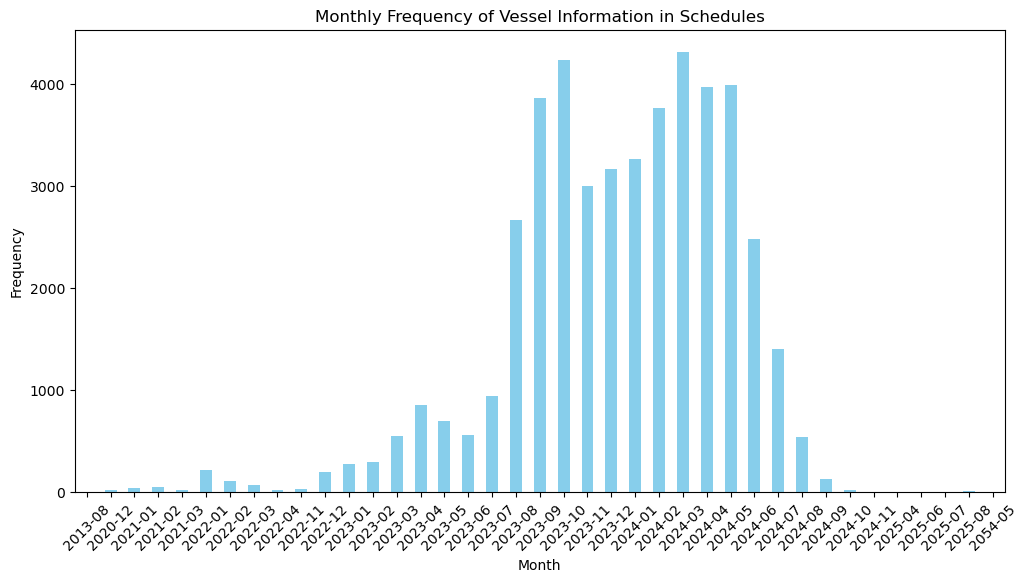

In [15]:
# Check information distribution in schedules
schedules['year_month'] = schedules['arrivalDate'].dt.to_period('M')

monthly_counts = schedules.groupby('year_month').size()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Monthly Frequency of Vessel Information in Schedules')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
schedules.drop(['year_month'], axis=1, inplace=True)

## Cleaning vessels data

In [16]:
vessels = pd.read_csv('vessels.csv', sep='|')
# Drop useless data
vessels.drop('GT', axis=1, inplace=True)
vessels.drop('NT', axis=1, inplace=True)
vessels.drop('depth', axis=1, inplace=True)
vessels.drop('draft', axis=1, inplace=True)
vessels.drop('homePort', axis=1, inplace=True)
vessels.drop('maxHeight', axis=1, inplace=True)
vessels.drop('maxWidth', axis=1, inplace=True)
# One hot encoding for vessels types
vessels = pd.get_dummies(vessels, columns=['vesselType']) #no drop_first to handle the NaN

In [17]:
comb = pd.merge(comb, vessels, on='vesselId', how='left')
comb.head(10)

# Added: shippingLineId | CEU | DWT | vesselType(1 Hot) | breath | lenght 

,time,cog,sog,rot,heading,etaStd,latitude,longitude,vesselId,portId,...,enginePower,freshWater,fuel,length,maxSpeed,rampCapacity,yearBuilt,vesselType_14.0,vesselType_21.0,vesselType_83.0
0,2024-01-01 00:00:25+00:00,284.0,0.7,0.0,88.0,2024-01-09 23:00:00+00:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,...,0.0,NaN,NaN,199.00,NaN,NaN,2004,False,False,True
1,2024-01-01 00:00:36+00:00,109.6,0.0,-6.0,347.0,2023-12-29 20:00:00+00:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,...,15100.0,663.0,2742.0,199.97,22.5,NaN,2012,False,False,True
2,2024-01-01 00:01:45+00:00,111.0,11.0,0.0,112.0,2024-01-02 09:00:00+00:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,...,0.0,NaN,NaN,199.00,NaN,NaN,2005,False,False,True
3,2024-01-01 00:03:11+00:00,96.4,0.0,0.0,142.0,2023-12-31 20:00:00+00:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,...,0.0,NaN,NaN,199.00,NaN,NaN,1995,False,False,True
4,2024-01-01 00:03:51+00:00,214.0,19.7,0.0,215.0,2024-01-25 12:00:00+00:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,...,15130.0,331.0,2951.0,199.95,22.4,NaN,2010,False,False,True
5,2024-01-01 00:05:13+00:00,186.9,0.0,0.0,187.0,2023-12-20 02:40:00+00:00,24.27431,-110.32727,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,16200.0,NaN,NaN,193.00,NaN,NaN,2009,False,True,False
6,2024-01-01 00:05:40+00:00,123.4,0.0,NaN,NaN,2023-12-16 01:00:00+00:00,40.71466,29.46603,61e9f46bb937134a3c4c02b3,61d38259b7b7526e1adf3a41,...,0.0,NaN,NaN,200.00,NaN,NaN,2011,False,True,False
7,2024-01-01 00:05:49+00:00,151.2,0.0,0.0,20.0,2023-12-31 18:30:00+00:00,-19.25026,146.83507,61e9f3bfb937134a3c4bfe9f,61d36f6e0a1807568ff9a115,...,14121.0,420.0,3288.0,199.94,21.0,NaN,1998,False,False,True
8,2024-01-01 00:06:18+00:00,265.0,0.1,0.0,122.0,2023-12-30 19:00:00+00:00,-26.73068,153.29194,61e9f45bb937134a3c4c0221,61d36f640a1807568ff9a103,...,12210.0,346.0,2408.0,183.00,22.2,NaN,2011,False,False,True
9,2024-01-01 00:06:29+00:00,36.0,0.0,0.0,70.0,2023-12-30 19:55:00+00:00,35.46922,139.68343,61e9f3e6b937134a3c4bff6d,61d379f61366c3998241d8d2,...,14160.0,405.0,3101.0,199.54,21.9,NaN,2003,False,False,True


## Cleaning ports data

In [18]:
ports = pd.read_csv('ports.csv', sep='|')
# Drop useless
ports.drop('name', axis=1, inplace=True)
ports.drop('portLocation', axis=1, inplace=True)
ports.drop('countryName', axis=1, inplace=True)
ports.drop('UN_LOCODE', axis=1, inplace=True)
ports.drop('ISO', axis=1, inplace=True)
# Rename to differenciate
ports.rename(columns={'longitude': 'portLongitude', 'latitude': 'portLatitude'}, inplace=True)

In [19]:
comb = pd.merge(comb, ports, on='portId', how='left')
comb.head(10)
# Added: portLongitude | portLatitude

,time,cog,sog,rot,heading,etaStd,latitude,longitude,vesselId,portId,...,fuel,length,maxSpeed,rampCapacity,yearBuilt,vesselType_14.0,vesselType_21.0,vesselType_83.0,portLongitude,portLatitude
0,2024-01-01 00:00:25+00:00,284.0,0.7,0.0,88.0,2024-01-09 23:00:00+00:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,...,NaN,199.00,NaN,NaN,2004,False,False,True,-71.618889,-33.587500
1,2024-01-01 00:00:36+00:00,109.6,0.0,-6.0,347.0,2023-12-29 20:00:00+00:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,...,2742.0,199.97,22.5,NaN,2012,False,False,True,-79.533000,8.967000
2,2024-01-01 00:01:45+00:00,111.0,11.0,0.0,112.0,2024-01-02 09:00:00+00:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,...,NaN,199.00,NaN,NaN,2005,False,False,True,-76.558889,39.232500
3,2024-01-01 00:03:11+00:00,96.4,0.0,0.0,142.0,2023-12-31 20:00:00+00:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,...,NaN,199.00,NaN,NaN,1995,False,False,True,150.899444,-34.462500
4,2024-01-01 00:03:51+00:00,214.0,19.7,0.0,215.0,2024-01-25 12:00:00+00:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,...,2951.0,199.95,22.4,NaN,2010,False,False,True,-5.817000,35.783000
5,2024-01-01 00:05:13+00:00,186.9,0.0,0.0,187.0,2023-12-20 02:40:00+00:00,24.27431,-110.32727,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,NaN,193.00,NaN,NaN,2009,False,True,False,-109.054444,25.594167
6,2024-01-01 00:05:40+00:00,123.4,0.0,NaN,NaN,2023-12-16 01:00:00+00:00,40.71466,29.46603,61e9f46bb937134a3c4c02b3,61d38259b7b7526e1adf3a41,...,NaN,200.00,NaN,NaN,2011,False,True,False,29.841944,40.751111
7,2024-01-01 00:05:49+00:00,151.2,0.0,0.0,20.0,2023-12-31 18:30:00+00:00,-19.25026,146.83507,61e9f3bfb937134a3c4bfe9f,61d36f6e0a1807568ff9a115,...,3288.0,199.94,21.0,NaN,1998,False,False,True,151.252778,-23.830000
8,2024-01-01 00:06:18+00:00,265.0,0.1,0.0,122.0,2023-12-30 19:00:00+00:00,-26.73068,153.29194,61e9f45bb937134a3c4c0221,61d36f640a1807568ff9a103,...,2408.0,183.00,22.2,NaN,2011,False,False,True,153.169444,-27.382500
9,2024-01-01 00:06:29+00:00,36.0,0.0,0.0,70.0,2023-12-30 19:55:00+00:00,35.46922,139.68343,61e9f3e6b937134a3c4bff6d,61d379f61366c3998241d8d2,...,3101.0,199.54,21.9,NaN,2003,False,False,True,139.667778,35.436389


# FEATURE ENGINEERING

In [20]:
# Sort train data on vesselId and by time
comb = comb.sort_values(by=['vesselId', 'time'])

### Time since last data collection

In [21]:
comb['time_diff_minutes'] = comb.groupby('vesselId')['time'].diff().dt.total_seconds() / 60
# Make integer changing numbers 0<x<1 to one so that the 0 is only a separator between ships
comb['time_diff_minutes'] = comb['time_diff_minutes'].fillna(0).apply(lambda x: 1 if 0 < x < 1 else x).astype(int)

### Distance since last data collection

In [22]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [23]:
def calculate_distances(df):
    # Create new columns for previous latitude and longitude
    df['prev_latitude'] = df.groupby('vesselId')['latitude'].shift(1)
    df['prev_longitude'] = df.groupby('vesselId')['longitude'].shift(1)

    # Calculate distance between current and previous position
    df['distance_km'] = df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], 
                               row['prev_latitude'], row['prev_longitude']) 
                     if pd.notna(row['prev_latitude']) and pd.notna(row['prev_longitude']) 
                     else np.nan, axis=1)
    
    # Drop the helper columns if not needed
    df.drop(columns=['prev_latitude', 'prev_longitude'], inplace=True)

    return df

In [24]:
comb = calculate_distances(comb)

### Calculate average speed in previous stretch

In [25]:
comb['mph_last_stretch'] = (comb['distance_km'] *  0.621371) / (comb['time_diff_minutes'] / 60)

In [26]:
# Remove unrealist values over the datadase
comb = comb[(comb['mph_last_stretch']<60) | (comb['mph_last_stretch'].isna())] 

## Lag features and moving average

In [27]:
# Lagging features 
comb['latitude_lag1'] = comb.groupby('vesselId')['latitude'].shift(1)
comb['longitude_lag1'] = comb.groupby('vesselId')['longitude'].shift(1)
comb['mph_last_stretch_lag'] = comb.groupby('vesselId')['mph_last_stretch'].shift(1)
comb['distance_km_lag'] = comb.groupby('vesselId')['distance_km'].shift(1)

## Time sin/cos encoding

In [29]:
# Separate Date-Time in single attributes
comb['year_rec'] = comb['time'].dt.year
comb['month_rec'] = comb['time'].dt.month
comb['day_rec'] = comb['time'].dt.day
comb['hour_rec'] = comb['time'].dt.hour
comb['minute_rec'] = comb['time'].dt.minute



comb['year_eta'] = comb['etaStd'].dt.year.fillna(0).astype('int32')
comb['month_eta'] = comb['etaStd'].dt.month.fillna(0).astype('int32')
comb['day_eta'] = comb['etaStd'].dt.day.fillna(0).astype('int32')
comb['hour_eta'] = comb['etaStd'].dt.hour.fillna(0).astype('int32')
comb['minute_eta'] = comb['etaStd'].dt.minute.fillna(0).astype('int32')


In [31]:
def get_month_progress(row, time_type = '_rec'):
    if row[f'month{time_type}'] == 0:
        return np.nan
    days_in_month = monthrange(row[f'year{time_type}'], row[f'month{time_type}'])[1]
    day_progress = (row[f'day{time_type}'] - 1 + row[f'hour{time_type}']/24 + row[f'minute{time_type}']/(24*60)) / days_in_month
    return day_progress

In [32]:
# Recordings time
comb['month_sin_rec'] = np.sin(2 * np.pi * comb['month_rec'] / 12)
comb['month_cos_rec'] = np.cos(2 * np.pi * comb['month_rec'] / 12)

comb['day_progress_rec'] = comb.apply(lambda row: get_month_progress(row, '_rec'), axis=1)
comb['day_sin_rec'] = np.sin(2 * np.pi * comb['day_progress_rec'])
comb['day_cos_rec'] = np.cos(2 * np.pi * comb['day_progress_rec'])

hour_progress = comb['hour_rec'] + comb['minute_rec']/60
comb['hour_sin_rec'] = np.sin(2 * np.pi * hour_progress / 24)
comb['hour_cos_rec'] = np.cos(2 * np.pi * hour_progress / 24)

comb['minute_sin_rec'] = np.sin(2 * np.pi * comb['minute_rec'] / 60)
comb['minute_cos_rec'] = np.cos(2 * np.pi * comb['minute_rec'] / 60)



# ETA
comb['month_sin_eta'] = np.sin(2 * np.pi * comb['month_eta'] / 12)
comb['month_cos_eta'] = np.cos(2 * np.pi * comb['month_eta'] / 12)

comb['day_progress_eta'] = comb.apply(lambda row: get_month_progress(row, '_eta'), axis=1)
comb['day_sin_eta'] = np.sin(2 * np.pi * comb['day_progress_eta'])
comb['day_cos_eta'] = np.cos(2 * np.pi * comb['day_progress_eta'])

hour_progress = comb['hour_eta'] + comb['minute_eta']/60
comb['hour_sin_eta'] = np.sin(2 * np.pi * hour_progress / 24)
comb['hour_cos_eta'] = np.cos(2 * np.pi * hour_progress / 24)


## Add a flag if there's a probability of looking at a new trip 

In [33]:
# Selecting a threshold where we tell the model to consider the posibility of a new trip starting
# Current: 8h20m, 200km traveled (15mph avg speed)
# Not realistic but reasonable to consider shorter path for training
# Maybe change later
comb['new_trip'] = np.where(
    (comb['time_diff_minutes'] == 0) | (comb['time_diff_minutes'] >= 500) |
    (comb['distance_km'].isna()) | (comb['distance_km'] >= 200),
    1, 0  # Set to 1 if conditions are met, else 0
)
# Might add differerence in eta as an indicator

# TRAINING

In [34]:
comb.dtypes

time                    datetime64[ns, UTC]
cog                                 float64
sog                                 float64
rot                                 float64
heading                             float64
etaStd                  datetime64[ns, UTC]
latitude                            float64
longitude                           float64
vesselId                             object
portId                               object
source                               object
ID                                  float64
scaling_factor                      float64
uncertain_rot                         int64
navstat_1.0                            bool
navstat_2.0                            bool
navstat_3.0                            bool
navstat_4.0                            bool
navstat_5.0                            bool
navstat_6.0                            bool
navstat_7.0                            bool
navstat_8.0                            bool
navstat_9.0                     

In [35]:
# Encode IDs 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
comb['vesselId_encoded'] = label_encoder.fit_transform(comb['vesselId'])
comb['portId_encoded'] = label_encoder.fit_transform(comb['portId'])
comb['shippingLineId_encoded'] = label_encoder.fit_transform(comb['shippingLineId'])

# Drop non valid columns
comb.drop(columns=['vesselId'], inplace=True)
comb.drop(columns=['portId'], inplace=True)
comb.drop(columns=['shippingLineId'], inplace=True)
comb.drop(columns=['time'], inplace=True)
comb.drop(columns=['etaStd'], inplace=True)

# Split data after porcessing
train_separated = comb[comb['source'] == 'train']
test_separated = comb[comb['source'] == 'train']

In [36]:
train_separated.shape[0]

1521790

In [37]:
test_separated.shape[0]

1521790

In [38]:
test_separated.drop(columns=['source'], inplace=True)
train_separated.drop(columns=['source'], inplace=True)

/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_23597/3085919832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_separated.drop(columns=['source'], inplace=True)
/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_23597/3085919832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_separated.drop(columns=['source'], inplace=True)


In [39]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Replace 'target_column1' and 'target_column2' with the names of your target columns
target_columns = ['latitude', 'longitude']
X_train = train_separated.drop(columns=target_columns)
y_train = train_separated[target_columns]

X_test = test_separated.drop(columns=target_columns)

# Instantiate the multi-output model with XGBoost as the base regressor
multi_output_model = MultiOutputRegressor(XGBRegressor(enable_categorical=True))

# Train the model
multi_output_model.fit(X_train, y_train)

# Now you can use multi_output_model to predict on new data
y_pred = multi_output_model.predict(X_test)

In [40]:
# Now you can use multi_output_model to predict on new data
y_pred = multi_output_model.predict(X_test)

In [42]:
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_longitude', 'predicted_latitude'])
y_pred_df.head(100)

,predicted_longitude,predicted_latitude
0,4.735960,73.181641
1,7.531565,73.223022
2,8.068052,73.500984
3,8.066360,73.484375
4,8.248531,73.484375
5,8.244647,73.484375
6,8.419604,73.484375
7,8.419604,73.484375
8,8.419604,73.484375
9,8.419604,73.484375


In [44]:
y_pred_df.to_csv('result_0.1.csv', index=False)